# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

The task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. We'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, we can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

We'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sb
% matplotlib inline

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Exploration and Cleaning

In [2]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


The channels column will have to be cleaned so that each channel has its own binary value column indicating whether or not it's used for that particular offer. Overall, there appear to be four BOGO, four discount and two informational types of offers in the portfolio. It may be a useful exercise to determine what demographic factors best determine if someone should be targeted with a BOGO or discount offer. Informational offers can be disregarded since they don't provide any rewards.

In [3]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [4]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


The maximum age of the app users is 118 years, which seems like it should be an outlier. The distribution of age and income, the two numerical demographic data features, are plotted below.

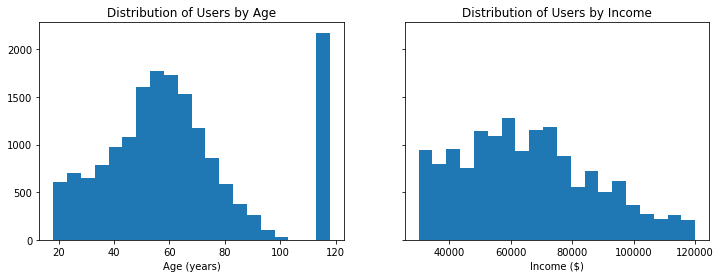

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12,4), sharey=True)

ax[0].hist(profile['age'], bins=20)
ax[0].set_title('Distribution of Users by Age')
ax[0].set_xlabel('Age (years)');

ax[1].hist(profile['income'].dropna(), bins=20)
ax[1].set_title('Distribution of Users by Income')
ax[1].set_xlabel('Income ($)');

There is a large bar at 118 years old, taller than all the other bars. That doesn't make sense, so let's look at what kind of data these 118-year-old users have.

In [6]:
profile[profile['age'] == 118].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 16994
Data columns (total 5 columns):
age                 2175 non-null int64
became_member_on    2175 non-null int64
gender              0 non-null object
id                  2175 non-null object
income              0 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 102.0+ KB


Any entry that has the age of 118 does not contain demographic information. This will be useful for cleaning out data points that do not contain information about relevant features.

In [7]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


The value column shows the offer ID as a dictionary value, so this will also have to be extracted in the cleaning steps.

In [8]:
transcript.shape

(306534, 4)

First I separate the channel types into their own columns in the offer portfolio.

In [9]:
channels = set([channel for list_ in portfolio['channels'] for channel in list_])

for channel in channels:
    portfolio[channel] = portfolio['channels'].apply(lambda x: 1 if channel in x else 0)

In [10]:
portfolio.drop(columns='channels', inplace=True)

In [11]:
portfolio

,difficulty,duration,id,offer_type,reward,email,web,mobile,social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,0,1,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,1,0


All ages that are labeled 118 are replaced with NaN since that is not a valid age and is repeated for multiple data points without demographic information.

In [12]:
profile['age'].replace(118, np.nan, inplace=True)
profile.head()

,age,became_member_on,gender,id,income
0,NaN,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,NaN,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,NaN,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


Offer IDs are extracted from the value column in the transcript table, then the two offer ID columns are combined into one.

In [13]:
records = set([key for dict_ in transcript['value'] for key in dict_])

for record in records:
    transcript[record] = transcript['value'].apply(lambda x: x[record] if record in x else np.nan)

In [14]:
transcript.head()

,event,person,time,value,offer_id,reward,amount,offer id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},NaN,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [15]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 8 columns):
event       306534 non-null object
person      306534 non-null object
time        306534 non-null int64
value       306534 non-null object
offer_id    33579 non-null object
reward      33579 non-null float64
amount      138953 non-null float64
offer id    134002 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 18.7+ MB


In [16]:
# The two offer ID columns are concatenated, with NaN values replaced with empty strings, and then all empty strings
# are replaced with NaN values. The redundant column is then deleted.

transcript['offer_id'] = transcript['offer id'].replace(np.nan, '') + transcript['offer_id'].replace(np.nan, '')
transcript['offer_id'].replace('', np.nan, inplace=True)
transcript.drop(columns=['value', 'offer id'], inplace=True)

In [17]:
profile.head()

,age,became_member_on,gender,id,income
0,NaN,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,NaN,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,NaN,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [18]:
profile[profile['age'].isna()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 16994
Data columns (total 5 columns):
age                 0 non-null float64
became_member_on    2175 non-null int64
gender              0 non-null object
id                  2175 non-null object
income              0 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 102.0+ KB


The transcript of all offers is merged with the demographic information of each unique user into one larger table using the user ID as the common key.

In [19]:
df_merged = pd.merge(transcript, profile, left_on='person', right_on='id')
df_merged.drop(columns='id', inplace=True)
df_merged.head(20)

,event,person,time,offer_id,reward,amount,age,became_member_on,gender,income
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,75.0,20170509,F,100000.0
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,75.0,20170509,F,100000.0
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,NaN,NaN,19.89,75.0,20170509,F,100000.0
3,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,NaN,75.0,20170509,F,100000.0
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,NaN,NaN,17.78,75.0,20170509,F,100000.0
5,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,75.0,20170509,F,100000.0
6,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,216,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,75.0,20170509,F,100000.0
7,transaction,78afa995795e4d85b5d9ceeca43f5fef,222,NaN,NaN,19.67,75.0,20170509,F,100000.0
8,transaction,78afa995795e4d85b5d9ceeca43f5fef,240,NaN,NaN,29.72,75.0,20170509,F,100000.0
9,transaction,78afa995795e4d85b5d9ceeca43f5fef,378,NaN,NaN,23.93,75.0,20170509,F,100000.0


In [20]:
df_merged.shape

(306534, 10)

In [21]:
df_merged[df_merged['offer_id'].isna()]['event'].unique()

array(['transaction'], dtype=object)

A new table of only all the transactions, which are simple purchases made with no promotional offers, is separated from the full table of transcations and offers and has only entries with demographic data retained.

In [22]:
transactions = df_merged[df_merged['event'] == 'transaction'].drop(columns=['event', 'offer_id', 'reward'])

In [23]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138953 entries, 2 to 306533
Data columns (total 7 columns):
person              138953 non-null object
time                138953 non-null int64
amount              138953 non-null float64
age                 123957 non-null float64
became_member_on    138953 non-null int64
gender              123957 non-null object
income              123957 non-null float64
dtypes: float64(3), int64(2), object(2)
memory usage: 8.5+ MB


In [24]:
# All rows with NaN values for age/gender/income are dropped from the transactions DataFrame.

transactions = transactions[~transactions['age'].isna()]

In [25]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123957 entries, 2 to 306519
Data columns (total 7 columns):
person              123957 non-null object
time                123957 non-null int64
amount              123957 non-null float64
age                 123957 non-null float64
became_member_on    123957 non-null int64
gender              123957 non-null object
income              123957 non-null float64
dtypes: float64(3), int64(2), object(2)
memory usage: 7.6+ MB


A new DataFrame is extracted containing only promotional offers for users listed with demographic information, which is merged with the portfolio DataFrame containing information on those offers.

In [26]:
offers = df_merged[df_merged['event'] != 'transaction'].drop(columns='amount')
offers.head(20)

,event,person,time,offer_id,reward,age,became_member_on,gender,income
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75.0,20170509,F,100000.0
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75.0,20170509,F,100000.0
3,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,75.0,20170509,F,100000.0
5,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,5a8bc65990b245e5a138643cd4eb9837,NaN,75.0,20170509,F,100000.0
6,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,216,5a8bc65990b245e5a138643cd4eb9837,NaN,75.0,20170509,F,100000.0
10,offer received,78afa995795e4d85b5d9ceeca43f5fef,408,ae264e3637204a6fb9bb56bc8210ddfd,NaN,75.0,20170509,F,100000.0
11,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,408,ae264e3637204a6fb9bb56bc8210ddfd,NaN,75.0,20170509,F,100000.0
12,offer received,78afa995795e4d85b5d9ceeca43f5fef,504,f19421c1d4aa40978ebb69ca19b0e20d,NaN,75.0,20170509,F,100000.0
14,offer completed,78afa995795e4d85b5d9ceeca43f5fef,510,ae264e3637204a6fb9bb56bc8210ddfd,10.0,75.0,20170509,F,100000.0
15,offer completed,78afa995795e4d85b5d9ceeca43f5fef,510,f19421c1d4aa40978ebb69ca19b0e20d,5.0,75.0,20170509,F,100000.0


In [27]:
offers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167581 entries, 0 to 306532
Data columns (total 9 columns):
event               167581 non-null object
person              167581 non-null object
time                167581 non-null int64
offer_id            167581 non-null object
reward              33579 non-null float64
age                 148805 non-null float64
became_member_on    167581 non-null int64
gender              148805 non-null object
income              148805 non-null float64
dtypes: float64(3), int64(2), object(4)
memory usage: 12.8+ MB


In [28]:
offers[~offers['reward'].isna()]['event'].unique()

array(['offer completed'], dtype=object)

In [29]:
offers = pd.merge(offers, portfolio.drop(columns='reward'), left_on='offer_id', right_on='id')

In [30]:
offers.drop(columns=['id'], inplace=True)
offers.sort_values(by=['person', 'time'], inplace=True)

offers.head(20)

,event,person,time,offer_id,reward,age,became_member_on,gender,income,difficulty,duration,offer_type,email,web,mobile,social
29327,offer received,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837,NaN,33.0,20170421,M,72000.0,0,3,informational,1,0,1,1
29328,offer viewed,0009655768c64bdeb2e877511632db8f,192,5a8bc65990b245e5a138643cd4eb9837,NaN,33.0,20170421,M,72000.0,0,3,informational,1,0,1,1
92208,offer received,0009655768c64bdeb2e877511632db8f,336,3f207df678b143eea3cee63160fa8bed,NaN,33.0,20170421,M,72000.0,0,4,informational,1,1,1,0
92209,offer viewed,0009655768c64bdeb2e877511632db8f,372,3f207df678b143eea3cee63160fa8bed,NaN,33.0,20170421,M,72000.0,0,4,informational,1,1,1,0
66219,offer received,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,NaN,33.0,20170421,M,72000.0,5,5,bogo,1,1,1,1
66220,offer completed,0009655768c64bdeb2e877511632db8f,414,f19421c1d4aa40978ebb69ca19b0e20d,5.0,33.0,20170421,M,72000.0,5,5,bogo,1,1,1,1
66221,offer viewed,0009655768c64bdeb2e877511632db8f,456,f19421c1d4aa40978ebb69ca19b0e20d,NaN,33.0,20170421,M,72000.0,5,5,bogo,1,1,1,1
127587,offer received,0009655768c64bdeb2e877511632db8f,504,fafdcd668e3743c1bb461111dcafc2a4,NaN,33.0,20170421,M,72000.0,10,10,discount,1,1,1,1
127588,offer completed,0009655768c64bdeb2e877511632db8f,528,fafdcd668e3743c1bb461111dcafc2a4,2.0,33.0,20170421,M,72000.0,10,10,discount,1,1,1,1
127589,offer viewed,0009655768c64bdeb2e877511632db8f,540,fafdcd668e3743c1bb461111dcafc2a4,NaN,33.0,20170421,M,72000.0,10,10,discount,1,1,1,1


In [31]:
offers['offer_id'].unique()

array(['5a8bc65990b245e5a138643cd4eb9837',
       '3f207df678b143eea3cee63160fa8bed',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '2906b810c7d4411798c6938adc9daaa5',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '9b98b8c7a33c4b65b9aebfe6a799e6d9',
       'ae264e3637204a6fb9bb56bc8210ddfd',
       '4d5c57ea9a6940dd891ad53e9dbe8da0'], dtype=object)

In [32]:
offers = offers[~offers['age'].isna()]
offers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148805 entries, 29327 to 94622
Data columns (total 16 columns):
event               148805 non-null object
person              148805 non-null object
time                148805 non-null int64
offer_id            148805 non-null object
reward              32444 non-null float64
age                 148805 non-null float64
became_member_on    148805 non-null int64
gender              148805 non-null object
income              148805 non-null float64
difficulty          148805 non-null int64
duration            148805 non-null int64
offer_type          148805 non-null object
email               148805 non-null int64
web                 148805 non-null int64
mobile              148805 non-null int64
social              148805 non-null int64
dtypes: float64(3), int64(8), object(5)
memory usage: 19.3+ MB


Analysis of what factors best determine if an offer influences a viewer is best done using data from offers that were viewed by the users they were sent to. This is an important distinction to make since even if a user completes an offer, they weren't influenced by it if they didn't view it. Therefore, all viewed offers are separated into a new DataFrame.

In [33]:
viewed = offers[offers['event'] == 'offer viewed'][['person', 'offer_id']]
viewed.head(10)

,person,offer_id
29328,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837
92209,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed
66221,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d
127589,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4
83731,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed
151365,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2
18819,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837
70266,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7
3075,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9
111437,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4


In [34]:
viewed_offers = pd.merge(viewed, offers, how='inner', left_on=['person', 'offer_id'], right_on=['person', 'offer_id']).drop_duplicates()
viewed_offers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129323 entries, 0 to 170994
Data columns (total 16 columns):
person              129323 non-null object
offer_id            129323 non-null object
event               129323 non-null object
time                129323 non-null int64
reward              27365 non-null float64
age                 129323 non-null float64
became_member_on    129323 non-null int64
gender              129323 non-null object
income              129323 non-null float64
difficulty          129323 non-null int64
duration            129323 non-null int64
offer_type          129323 non-null object
email               129323 non-null int64
web                 129323 non-null int64
mobile              129323 non-null int64
social              129323 non-null int64
dtypes: float64(3), int64(8), object(5)
memory usage: 16.8+ MB


# Analysis
## Part 1: Transaction History

The first question to be addressed is what demographic features, if any, correlate to users' transaction statistics, namely the average transaction amount and number of transactions by user. This can prove useful in identifying what kinds of customers might be useful in targeting for a promotional offer that they are more likely to user when making purchases of a specific amount or at a given frequency. 

One way to answer this question is by performing a linear regression analysis between the transaction statistics and the quantitative demographic features, which may require creating dummy variables for non-numerical features.

In [35]:
# Dummy variabes are created from the gender column, which is the only non-numerical feature.
# The "other gender" column is removed, which allows for the female and male columns to be used
# in a regression analysis without being linearly dependent.

transactions = pd.get_dummies(transactions, columns=['gender'])
transactions.drop(columns='gender_O', inplace=True)

In [36]:
# A GroupBy object is created to calculate the transaction statistics by user.

user_groups = transactions.groupby('person', as_index=False)

### Average Amount

First the average amount is analyzed against the demographic features. A new DataFrame is created by merging the mean transaction amount, which is calculated using the GroupBy object above, with the original transaction DataFrame's demographic features.

In [37]:
mean_amounts = pd.merge(user_groups.mean()[['person', 'amount']],
         transactions.drop(columns=['time', 'amount']),
         left_on='person', right_on='person', how='inner').drop_duplicates()

In [38]:
mean_amounts.rename(columns={'amount': 'avg_amount'}, inplace=True)

In [39]:
mean_amounts.head()

,person,avg_amount,age,became_member_on,income,gender_F,gender_M
0,0009655768c64bdeb2e877511632db8f,15.950000,33.0,20170421,72000.0,0,1
8,0011e0d4e6b944f998e987f904e8c1e5,15.892000,40.0,20180109,57000.0,0,0
13,0020c2b971eb4e9188eac86d93036a77,24.607500,59.0,20160304,90000.0,1,0
21,0020ccbbb6d84e358d3414a3ff76cffd,12.837500,24.0,20161111,60000.0,1,0
33,003d66b6608740288d6cc97a6903f4f0,2.685556,26.0,20170621,73000.0,1,0


In [40]:
mean_amounts.describe()

,avg_amount,age,became_member_on,income,gender_F,gender_M
count,14492.000000,14492.000000,1.449200e+04,14492.000000,14492.000000,14492.000000
mean,15.252287,54.306100,2.016670e+07,65218.120342,0.413539,0.572385
std,16.543371,17.434828,1.190509e+04,21599.246904,0.492485,0.494750
min,0.150000,18.000000,2.013073e+07,30000.000000,0.000000,0.000000
25%,3.890833,42.000000,2.016051e+07,49000.000000,0.000000,0.000000
50%,14.311214,55.000000,2.017073e+07,63000.000000,0.000000,1.000000
75%,21.467625,66.000000,2.017123e+07,79000.000000,1.000000,1.000000
max,451.470000,101.000000,2.018073e+07,120000.000000,1.000000,1.000000


Now a linear regression model can be fitted between the average transaction amount and the demographic features. The numerical features are normalized to be roughly in the same 0-1 range.

In [41]:
X_amts = mean_amounts[['age', 'income', 'gender_F', 'gender_M']]
X_amts['age'] /= 100
X_amts['income'] /= 10000

y_amts = mean_amounts['avg_amount']

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [42]:
lm_amts = LinearRegression()
lm_amts.fit(X_amts, y_amts);

In [43]:
amts_feats = pd.DataFrame(data={'features': X_amts.columns,
                                'coefficients': lm_amts.coef_}).set_index('features')
amts_feats

,coefficients
features,
age,4.612618
income,3.530476
gender_F,0.740119
gender_M,-1.726766


In [44]:
lm_amts.score(X_amts, y_amts)

0.25042737185479924

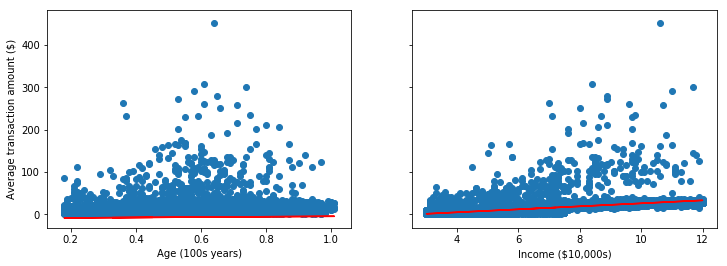

In [45]:
age_amt_slope = amts_feats.loc['age']['coefficients']
income_amt_slope = amts_feats.loc['income']['coefficients']

fig, ax = plt.subplots(1, 2, figsize=(12,4), sharey=True)

ax[0].scatter(X_amts['age'], y_amts)
ax[0].set_xlabel('Age (100s years)')
ax[0].set_ylabel('Average transaction amount ($)')
ax[0].plot(X_amts['age'], age_amt_slope * X_amts['age'] + lm_amts.intercept_, '-r')
ax[1].scatter(X_amts['income'], y_amts)
ax[1].set_xlabel('Income ($10,000s)')
ax[1].plot(X_amts['income'], income_amt_slope * X_amts['income'] + lm_amts.intercept_, '-r');

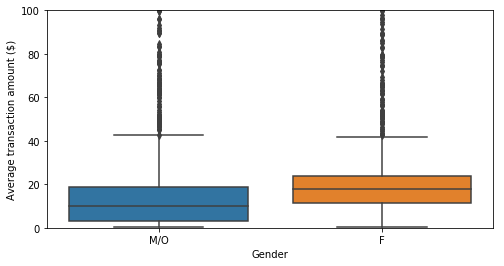

In [46]:
plt.figure(figsize=(8,4))
g = sb.boxplot(data=mean_amounts, x='gender_F', y='avg_amount')
g.set_xticklabels(['M/O', 'F'])
g.set_xlabel('Gender')
g.set_ylabel('Average transaction amount ($)')
g.set_ylim([0,100]);

While an R-squared score of 0.25 isn't very high for this linear regression model, we can conclude a few points from this analysis. For one thing, the average transaction amount appears to be more strongly linearly dependent on income than on age, which makes sense since users who earn more are likely to spend more on each transaction. More apparent, however, is the disparity between the average amount spend by women compared to men, which is about \$2.47 more. 

This could be a sign that lower income and especially male customers could be better targets for savings deals since they spend less on their purchases on average, and so savings offers could incentivize them to make more expensive purchases in order to complete those offers. 

### Number of Transactions

Next we attempt a similar linear regression model fitting demographic features to the number of transactions by user.

In [47]:
num_transactions = user_groups.count()[['person', 'amount']].rename(columns={'amount': 'num_transactions'})
num_transactions = pd.merge(num_transactions, transactions.drop(columns=['time', 'amount']),
         left_on='person', right_on='person', how='inner').drop_duplicates()

num_transactions.head()

,person,num_transactions,age,became_member_on,income,gender_F,gender_M
0,0009655768c64bdeb2e877511632db8f,8,33.0,20170421,72000.0,0,1
8,0011e0d4e6b944f998e987f904e8c1e5,5,40.0,20180109,57000.0,0,0
13,0020c2b971eb4e9188eac86d93036a77,8,59.0,20160304,90000.0,1,0
21,0020ccbbb6d84e358d3414a3ff76cffd,12,24.0,20161111,60000.0,1,0
33,003d66b6608740288d6cc97a6903f4f0,18,26.0,20170621,73000.0,1,0


In [48]:
X_counts = num_transactions[['age', 'income', 'gender_F', 'gender_M']]
X_counts['age'] /= 100
X_counts['income'] /= 100000

y_counts = num_transactions['num_transactions']

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [49]:
lm_counts = LinearRegression()
lm_counts.fit(X_counts, y_counts);

In [50]:
counts_feats = pd.DataFrame(data={'features': X_counts.columns,
                                'coefficients': lm_counts.coef_}).set_index('features')
counts_feats

,coefficients
features,
age,-2.398144
income,-5.683612
gender_F,0.052706
gender_M,-0.118133


In [51]:
lm_counts.score(X_counts, y_counts)

0.075305183845614576

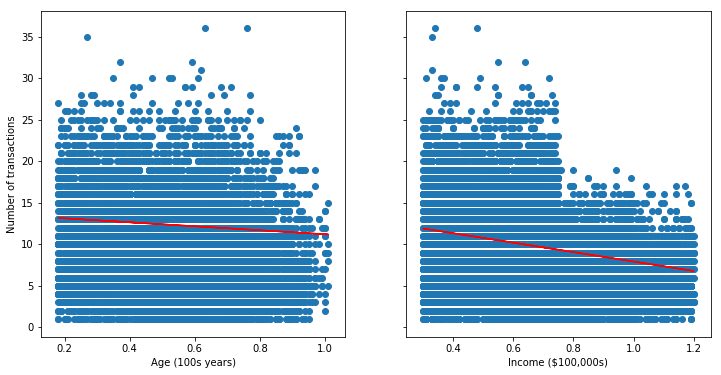

In [52]:
age_count_slope = counts_feats.loc['age']['coefficients']
income_count_slope = counts_feats.loc['income']['coefficients']

fig, ax = plt.subplots(1, 2, figsize=(12,6), sharey=True)

ax[0].scatter(X_counts['age'], y_counts)
ax[0].set_xlabel('Age (100s years)')
ax[0].set_ylabel('Number of transactions')
ax[0].plot(X_counts['age'], age_count_slope * X_counts['age'] + lm_counts.intercept_, '-r')
ax[1].scatter(X_counts['income'], y_counts)
ax[1].set_xlabel('Income ($100,000s)')
ax[1].plot(X_counts['income'], income_count_slope * X_counts['income'] + lm_counts.intercept_, '-r');

An R-squared score of 0.075 is much weaker than that of the previous linear regression model, and none of the coefficients point to any of the demographic features being particularly deterministic for the number of transactions by user. However, this data will be accounted for in the next analysis, where a classification model will be developed. 

The plot of number of transactions against income does show an abrupt dropoff in the maximum number of transations from about 25 to 15 at around $750,000 income. Despite the lack of linear dependence, this could be a useful detail in building a separate model to predict what is the maximum number of times someone may buy items on the app.

## Part 2: Offers
The next part of this analysis will be to identify what kinds of demographics might respond best to a buy-one-get-one-free (BOGO) or discount offer. As noted earlier, the offers we need to analyze must have been viewed, so we can determine whether or not the user completed them based on viewing the rewards and difficulty before. This will require a classification model that will be optimized using the F1-score in order to get good precision as well as recall.

### Cleaning
First I need to do some further manipulation of the DataFrame of viewed offers so that it includes the transaction statistics by user that were determined above.

In [53]:
viewed_offers = pd.merge(viewed_offers, mean_amounts[['person', 'avg_amount']],
                         left_on='person', right_on='person')
viewed_offers = pd.merge(viewed_offers, num_transactions[['person', 'num_transactions']],
                         left_on='person', right_on='person')

viewed_offers.head(20)

,person,offer_id,event,time,reward,age,became_member_on,gender,income,difficulty,duration,offer_type,email,web,mobile,social,avg_amount,num_transactions
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,offer received,168,NaN,33.0,20170421,M,72000.0,0,3,informational,1,0,1,1,15.950,8
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,offer viewed,192,NaN,33.0,20170421,M,72000.0,0,3,informational,1,0,1,1,15.950,8
2,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,offer received,336,NaN,33.0,20170421,M,72000.0,0,4,informational,1,1,1,0,15.950,8
3,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,offer viewed,372,NaN,33.0,20170421,M,72000.0,0,4,informational,1,1,1,0,15.950,8
4,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,offer received,408,NaN,33.0,20170421,M,72000.0,5,5,bogo,1,1,1,1,15.950,8
5,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,offer completed,414,5.0,33.0,20170421,M,72000.0,5,5,bogo,1,1,1,1,15.950,8
6,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,offer viewed,456,NaN,33.0,20170421,M,72000.0,5,5,bogo,1,1,1,1,15.950,8
7,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,offer received,504,NaN,33.0,20170421,M,72000.0,10,10,discount,1,1,1,1,15.950,8
8,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,offer completed,528,2.0,33.0,20170421,M,72000.0,10,10,discount,1,1,1,1,15.950,8
9,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,offer viewed,540,NaN,33.0,20170421,M,72000.0,10,10,discount,1,1,1,1,15.950,8


The next step is to create different DataFrames for completed and incomplete offers out of those that were viewed.

In [54]:
# This DataFrame contains all user and offer ID pairs for the completed offers.

completions = viewed_offers[viewed_offers['event'] == 'offer completed'][['person', 'offer_id']]
completions.head()

,person,offer_id
5,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d
8,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4
14,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2
19,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7
22,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9


In [55]:
# The full DataFrame of completed offers is created by merging the completions and viewed offers DataFrames
# based on common user and offer IDs, which excludes the incomplete offers.

completed_offers = pd.merge(completions, viewed_offers,
                            left_on=['person', 'offer_id'], right_on=['person', 'offer_id']).drop_duplicates()
completed_offers.head(20)

,person,offer_id,event,time,reward,age,became_member_on,gender,income,difficulty,duration,offer_type,email,web,mobile,social,avg_amount,num_transactions
0,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,offer received,408,NaN,33.0,20170421,M,72000.0,5,5,bogo,1,1,1,1,15.9500,8
1,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,offer completed,414,5.0,33.0,20170421,M,72000.0,5,5,bogo,1,1,1,1,15.9500,8
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,offer viewed,456,NaN,33.0,20170421,M,72000.0,5,5,bogo,1,1,1,1,15.9500,8
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,offer received,504,NaN,33.0,20170421,M,72000.0,10,10,discount,1,1,1,1,15.9500,8
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,offer completed,528,2.0,33.0,20170421,M,72000.0,10,10,discount,1,1,1,1,15.9500,8
5,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,offer viewed,540,NaN,33.0,20170421,M,72000.0,10,10,discount,1,1,1,1,15.9500,8
6,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,offer received,168,NaN,40.0,20180109,O,57000.0,7,7,discount,1,1,1,1,15.8920,5
7,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,offer viewed,186,NaN,40.0,20180109,O,57000.0,7,7,discount,1,1,1,1,15.8920,5
8,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,offer completed,252,3.0,40.0,20180109,O,57000.0,7,7,discount,1,1,1,1,15.8920,5
9,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer received,408,NaN,40.0,20180109,O,57000.0,20,10,discount,1,1,0,0,15.8920,5


In [56]:
# To obtain a DataFrame of incomplete offers, the viewed and completed offer DataFrames' rows are combined,
# and all rows that have duplicate entries, which are only the completed offers, are deleted.

incomplete_offers = pd.concat([viewed_offers, completed_offers]).drop_duplicates(keep=False)
incomplete_offers.head(20)

,person,offer_id,event,time,reward,age,became_member_on,gender,income,difficulty,duration,offer_type,email,web,mobile,social,avg_amount,num_transactions
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,offer received,168,NaN,33.0,20170421,M,72000.0,0,3,informational,1,0,1,1,15.950000,8
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,offer viewed,192,NaN,33.0,20170421,M,72000.0,0,3,informational,1,0,1,1,15.950000,8
2,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,offer received,336,NaN,33.0,20170421,M,72000.0,0,4,informational,1,1,1,0,15.950000,8
3,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,offer viewed,372,NaN,33.0,20170421,M,72000.0,0,4,informational,1,1,1,0,15.950000,8
10,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,offer received,0,NaN,40.0,20180109,O,57000.0,0,4,informational,1,1,1,0,15.892000,5
11,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,offer viewed,6,NaN,40.0,20180109,O,57000.0,0,4,informational,1,1,1,0,15.892000,5
15,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,offer received,336,NaN,40.0,20180109,O,57000.0,0,3,informational,1,0,1,1,15.892000,5
16,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,offer viewed,354,NaN,40.0,20180109,O,57000.0,0,3,informational,1,0,1,1,15.892000,5
31,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,offer received,504,NaN,59.0,20160304,F,90000.0,0,3,informational,1,0,1,1,24.607500,8
32,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,offer viewed,660,NaN,59.0,20160304,F,90000.0,0,3,informational,1,0,1,1,24.607500,8


We conduct a quick test to make sure that the completed and incomplete offers are separated into two DataFrames perfectly without any crossover and misses.

In [57]:
print(completed_offers['event'].unique())
print(incomplete_offers['event'].unique())
viewed_offers.shape[0] == completed_offers.shape[0] + incomplete_offers.shape[0]

['offer received' 'offer completed' 'offer viewed']
['offer received' 'offer viewed']


True

All offers have been compartmentalized into both DataFrames, and none of the completed offers are in the incomplete offers DataFrame, so we are good to proceed with the analysis.

### Analysis: BOGO

First we create a classification model to determine who is most likely to view and complete a BOGO offer. The completed and incomplete BOGO offers are separated from the completed offers DataFrame, and dummy classification variables are assigned such that 1 corresponds to completed offers and 0 to incomplete offers in order to fit the ensemble model. Then they are concatenated into one larger DataFrame of BOGO offers which is further cleaned by dropping unneeded columns, removing duplicated rows, and assigning dummy variables to the gender column

In [58]:
completed_bogo = completed_offers[completed_offers['offer_type'] == 'bogo']
completed_bogo['offer_completed'] = 1

incomplete_bogo = incomplete_offers[incomplete_offers['offer_type'] == 'bogo']
incomplete_bogo['offer_completed'] = 0

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [59]:
bogo = pd.concat([completed_bogo, incomplete_bogo])
bogo.head()

,person,offer_id,event,time,reward,age,became_member_on,gender,income,difficulty,duration,offer_type,email,web,mobile,social,avg_amount,num_transactions,offer_completed
0,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,offer received,408,NaN,33.0,20170421,M,72000.0,5,5,bogo,1,1,1,1,15.950,8,1
1,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,offer completed,414,5.0,33.0,20170421,M,72000.0,5,5,bogo,1,1,1,1,15.950,8,1
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,offer viewed,456,NaN,33.0,20170421,M,72000.0,5,5,bogo,1,1,1,1,15.950,8,1
12,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer received,504,NaN,40.0,20180109,O,57000.0,5,7,bogo,1,1,1,0,15.892,5,1
13,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer viewed,516,NaN,40.0,20180109,O,57000.0,5,7,bogo,1,1,1,0,15.892,5,1


In [60]:
bogo.drop(columns=['person', 'offer_id', 'event', 'time', 'reward'], inplace=True)
bogo.drop_duplicates(inplace=True)
bogo.head()

,age,became_member_on,gender,income,difficulty,duration,offer_type,email,web,mobile,social,avg_amount,num_transactions,offer_completed
0,33.0,20170421,M,72000.0,5,5,bogo,1,1,1,1,15.9500,8,1
12,40.0,20180109,O,57000.0,5,7,bogo,1,1,1,0,15.8920,5,1
25,59.0,20160304,F,90000.0,10,5,bogo,1,1,1,1,24.6075,8,1
31,24.0,20161111,F,60000.0,5,5,bogo,1,1,1,1,12.8375,12,1
34,24.0,20161111,F,60000.0,5,7,bogo,1,1,1,0,12.8375,12,1


In [61]:
bogo['gender_num'] = bogo['gender'].map({'M': 0, 'F': 1, 'O': 2})
bogo.head()

,age,became_member_on,gender,income,difficulty,duration,offer_type,email,web,mobile,social,avg_amount,num_transactions,offer_completed,gender_num
0,33.0,20170421,M,72000.0,5,5,bogo,1,1,1,1,15.9500,8,1,0
12,40.0,20180109,O,57000.0,5,7,bogo,1,1,1,0,15.8920,5,1,2
25,59.0,20160304,F,90000.0,10,5,bogo,1,1,1,1,24.6075,8,1,1
31,24.0,20161111,F,60000.0,5,5,bogo,1,1,1,1,12.8375,12,1,1
34,24.0,20161111,F,60000.0,5,7,bogo,1,1,1,0,12.8375,12,1,1


Now training and testing sets are constructed with a 70-30 randomly selected split, and we try fitting various ensemble classifier models to the data. First we start with a random forest classifier.

In [62]:
X_bogo = bogo[['age', 'gender_num', 'income', 'avg_amount', 'num_transactions']]
y_bogo = bogo['offer_completed']

In [63]:
X_bogo_train, X_bogo_test, y_bogo_train, y_bogo_test = train_test_split(X_bogo, y_bogo, test_size=0.3, random_state=42)

In [64]:
rf_bogo = RandomForestClassifier()
rf_bogo.fit(X_bogo_train, y_bogo_train)

print('Precision is {}'.format(precision_score(y_bogo_test, rf_bogo.predict(X_bogo_test))))
print('Recall is {}'.format(recall_score(y_bogo_test, rf_bogo.predict(X_bogo_test))))
print('F1 score is {}'.format(f1_score(y_bogo_test, rf_bogo.predict(X_bogo_test))))

Precision is 0.8181298255647698
Recall is 0.8292753623188406
F1 score is 0.8236648913199942


An F1-score of 82.36% and recall score of 82.93% aren't especially strong, particularly since we want the recall to be as high as possible. We look at tuning the hyperparameter of the number of decision tree estimators.

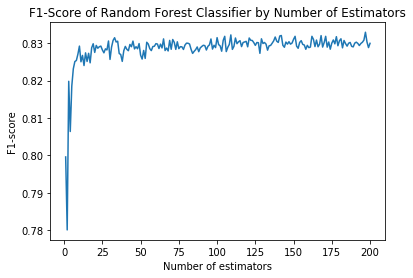

In [77]:
num_estimator_array = np.arange(1, 201)
f1_scores = []
for n_estimators in num_estimator_array:
    rf_bogo = RandomForestClassifier(n_estimators=n_estimators)
    rf_bogo.fit(X_bogo_train, y_bogo_train)
    f1_scores.append(f1_score(y_bogo_test, rf_bogo.predict(X_bogo_test)))

plt.plot(num_estimator_array, f1_scores);
plt.xlabel('Number of estimators')
plt.ylabel('F1-score')
plt.title('F1-Score of Random Forest Classifier by Number of Estimators');

The F1-score doesn't change much at all from around 83% regardless of the number of estimators used. Let's try testing an AdaBoost classifier, plotting the F1-score against the same hyperparameter.

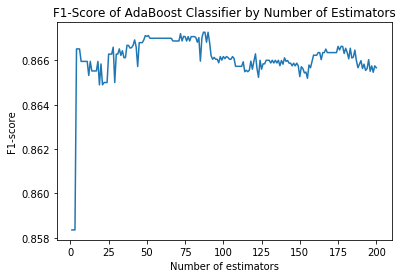

In [78]:
num_estimator_array = np.arange(1, 201)
f1_scores = []
for n_estimators in num_estimator_array:
    ada_bogo = AdaBoostClassifier(n_estimators=n_estimators)
    ada_bogo.fit(X_bogo_train, y_bogo_train)
    f1_scores.append(f1_score(y_bogo_test, ada_bogo.predict(X_bogo_test)))

plt.plot(num_estimator_array, f1_scores);
plt.xlabel('Number of estimators')
plt.ylabel('F1-score')
plt.title('F1-Score of AdaBoost Classifier by Number of Estimators');

The F1-score appears to be around its maximum amount for the default number of estimators at 50, so we'll use that in fitting the data and we'll determine all the scores of interest using this AdaBoost classifier model.

In [79]:
ada_bogo = AdaBoostClassifier()
ada_bogo.fit(X_bogo_train, y_bogo_train)

print('Precision is {}'.format(precision_score(y_bogo_test, ada_bogo.predict(X_bogo_test))))
print('Recall is {}'.format(recall_score(y_bogo_test, ada_bogo.predict(X_bogo_test))))
print('F1 score is {}'.format(f1_score(y_bogo_test, ada_bogo.predict(X_bogo_test))))

Precision is 0.8430996714129244
Recall is 0.8924637681159421
F1 score is 0.867079695860321


In [80]:
bogo_features = pd.DataFrame(data={'features': X_bogo.columns,
                              'importance': ada_bogo.feature_importances_})
bogo_features

,features,importance
0,age,0.04
1,gender_num,0.02
2,income,0.08
3,avg_amount,0.58
4,num_transactions,0.28


The F1-score, which is generally an informative measure for binary classification models as a balance between precision and recall, is 86.71%. The precision score is 84.31% and the recall score is 89.25%. Essentially, this means that a basic AdaBoost model is better at identifying more of the users who respond to a BOGO offer than finding more of those users out of those it identifies as those who would respond to an offer. 

In order to maximize promotional offer outreach and expand the customer base, recall would be a better scoring metric to use than precision since it's not a high priority to minimize the number of offers sent to those who aren't likely to respond. That said, this F1-score means that the basic AdaBoost model works well for identifying users who respond to BOGO offers. In order to improve the F1-score, more data on the types of items that were bought, as well as on other demographic features such as population density and education level, can be collected and fed into the model in order to minimize underfitting. 

The top model features with >90% total importance in determining who would likely respond to a BOGO offer are average transaction amount, number of transaction and income respectively. Age and gender were relatively insignificant as demographic features in determining responses to BOGO offers. 

### Analysis: Discounts

Now we apply the same steps from above to constructing a binary classification model to determine who would best respond to a discount offer.

In [81]:
completed_discount = completed_offers[completed_offers['offer_type'] == 'discount']
completed_discount['offer_completed'] = 1

incomplete_discount = incomplete_offers[incomplete_offers['offer_type'] == 'discount']
incomplete_discount['offer_completed'] = 0

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [82]:
discount = pd.concat([completed_discount, incomplete_discount])
discount.head()

,person,offer_id,event,time,reward,age,became_member_on,gender,income,difficulty,duration,offer_type,email,web,mobile,social,avg_amount,num_transactions,offer_completed
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,offer received,504,NaN,33.0,20170421,M,72000.0,10,10,discount,1,1,1,1,15.950,8,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,offer completed,528,2.0,33.0,20170421,M,72000.0,10,10,discount,1,1,1,1,15.950,8,1
5,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,offer viewed,540,NaN,33.0,20170421,M,72000.0,10,10,discount,1,1,1,1,15.950,8,1
6,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,offer received,168,NaN,40.0,20180109,O,57000.0,7,7,discount,1,1,1,1,15.892,5,1
7,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,offer viewed,186,NaN,40.0,20180109,O,57000.0,7,7,discount,1,1,1,1,15.892,5,1


In [83]:
discount.drop(columns=['person', 'offer_id', 'event', 'time', 'reward'], inplace=True)
discount.drop_duplicates(inplace=True)
discount.head()

,age,became_member_on,gender,income,difficulty,duration,offer_type,email,web,mobile,social,avg_amount,num_transactions,offer_completed
3,33.0,20170421,M,72000.0,10,10,discount,1,1,1,1,15.9500,8,1
6,40.0,20180109,O,57000.0,7,7,discount,1,1,1,1,15.8920,5,1
9,40.0,20180109,O,57000.0,20,10,discount,1,1,0,0,15.8920,5,1
15,59.0,20160304,F,90000.0,10,10,discount,1,1,1,1,24.6075,8,1
28,24.0,20161111,F,60000.0,7,7,discount,1,1,1,1,12.8375,12,1


In [84]:
discount['gender_num'] = discount['gender'].map({'M': 0, 'F': 1, 'O': 2})
discount.head()

,age,became_member_on,gender,income,difficulty,duration,offer_type,email,web,mobile,social,avg_amount,num_transactions,offer_completed,gender_num
3,33.0,20170421,M,72000.0,10,10,discount,1,1,1,1,15.9500,8,1,0
6,40.0,20180109,O,57000.0,7,7,discount,1,1,1,1,15.8920,5,1,2
9,40.0,20180109,O,57000.0,20,10,discount,1,1,0,0,15.8920,5,1,2
15,59.0,20160304,F,90000.0,10,10,discount,1,1,1,1,24.6075,8,1,1
28,24.0,20161111,F,60000.0,7,7,discount,1,1,1,1,12.8375,12,1,1


In [85]:
X_discount = discount[['age', 'gender_num', 'income', 'avg_amount', 'num_transactions']]
y_discount = discount['offer_completed']

In [86]:
X_discount_train, X_discount_test, y_discount_train, y_discount_test = train_test_split(X_discount, y_discount, test_size=0.3, random_state=42)

The same model with the same parameters as that for the BOGO offer classification is used to keep the analysis consistent.

In [87]:
ada_discount = AdaBoostClassifier()
ada_discount.fit(X_discount_train, y_discount_train)

print('Precision is {}'.format(precision_score(y_discount_test, ada_discount.predict(X_discount_test))))
print('Recall is {}'.format(recall_score(y_discount_test, ada_discount.predict(X_discount_test))))
print('F1 score is {}'.format(f1_score(y_discount_test, ada_discount.predict(X_discount_test))))

Precision is 0.8885691865027465
Recall is 0.9360705428492698
F1 score is 0.9117015566290928


In [88]:
discount_features = pd.DataFrame(data={'features': X_discount.columns,
                              'importance': ada_discount.feature_importances_})
discount_features

,features,importance
0,age,0.08
1,gender_num,0.00
2,income,0.20
3,avg_amount,0.40
4,num_transactions,0.32


This model now has a stronger F1-score than that for the BOGO offers at 91.17%, while the precision is 88.86% and the recall is 93.61%. Once again, having a stronger recall score would likely be more important than a stronger precision score, but the F1-score shows that the simple AdaBoost model is even better at identifying users who respond to discount offers. These scores could be improved further by having more transaction and demographic data to feed into the model, as discussed above. 

The top three features of >90% importance total are once again the average transaction amount, number of transactions, and income. However, income plays a greater role in determining whether a user responds to a discount offer than for BOGO offers compared to the transaction statistics.